In [1]:
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scipy.stats as s
import scipy.special as ss
import sortedcontainers as sc
import os
import tqdm
import matplotlib

In [2]:
os.environ["CAPY_REF_FA"] = "/home/opriebe/data/ref/hg19/Homo_sapiens_assembly19.fasta"
import hapaseg.coverage_MCMC as mcmc_cov
import hapaseg.NB_coverage_MCMC as nb_cov
from capy import mut, seq

Cannot find path to gnomAD index; gnomAD functionality disabled.


Load MCMC trace over SNP DP cluster assignments. Still looking at only the high purity exome

In [3]:
colors = mpl.cm.get_cmap("tab10").colors

### Load coverage

In [4]:
Cov = pd.read_csv("exome/6_C1D1_META.cov", sep = "\t", names = ["chr", "start", "end", "covcorr", "covraw"], low_memory=False)
Cov["chr"] = mut.convert_chr(Cov["chr"])
Cov = Cov.loc[Cov["chr"] != 0]
Cov["start_g"] = seq.chrpos2gpos(Cov["chr"], Cov["start"])
Cov["end_g"] = seq.chrpos2gpos(Cov["chr"], Cov["end"])

### Load covariates

In [5]:
Cov["C_len"] = Cov["end"] - Cov["start"] + 1

# load repl timing
F = pd.read_pickle("covars/GSE137764_H1.hg19_liftover.pickle")

# map targets to RT intervals
tidx = mut.map_mutations_to_targets(Cov.rename(columns = { "start" : "pos" }), F, inplace = False)
Cov.loc[tidx.index, "C_RT"] = F.iloc[tidx, 3:].mean(1).values

# z-transform
Cov["C_RT_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_RT"] + 1e-20))

#load GC content
B = pd.read_pickle("covars/GC.pickle")
Cov = Cov.merge(B.rename(columns = { "gc" : "C_GC" }), left_on = ["chr", "start", "end"], right_on = ["chr", "start", "end"], how = "left")
Cov["C_GC_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_GC"] + 1e-20))

In [6]:
clust = np.load("exome/6_C1D1_META.DP_clusts.auto_ref_correct.overdispersion92.no_phase_correct.npz")

#### Load chromosome boundary coordinates

In [7]:
allelic_segs = pd.read_pickle("exome/6_C1D1_META.allelic_segs.auto_ref_correct.overdispersion92.no_phase_correct.pickle")
chrbdy = allelic_segs.dropna().loc[:, ["start", "end"]]
chr_ends = chrbdy.loc[chrbdy["start"] != 0, "end"].cumsum()

In [8]:
clust["snps_to_clusters"].shape

(500, 11768)

In [9]:
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

### load SNPs from single DP iteration

In [10]:
iter_ind = 499
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

#assign coverage intervals to clusters
Cov_clust_probs = np.zeros([len(Cov), clust_u.max()])

for targ, snp_idx in SNPs.groupby("tidx").indices.items():
    targ_clust_hist = np.bincount(clust_uj[499, snp_idx].ravel(), minlength = clust_u.max())

    Cov_clust_probs[int(targ), :] = targ_clust_hist/targ_clust_hist.sum()

#subset intervals containing SNPs
overlap_idx = Cov_clust_probs.sum(1) > 0
Cov_clust_probs_overlap = Cov_clust_probs[overlap_idx, :]

#prune improbable assignments
Cov_clust_probs_overlap[Cov_clust_probs_overlap < 0.05] = 0
Cov_clust_probs_overlap /= Cov_clust_probs_overlap.sum(1)[:, None]
prune_idx = Cov_clust_probs_overlap.sum(0) > 0
Cov_clust_probs_overlap = Cov_clust_probs_overlap[:, prune_idx]

In [11]:
import scipy.stats
assgn_entropy = scipy.stats.entropy(Cov_clust_probs_overlap, axis=1)
entropy_idx = (assgn_entropy == 0)

#subsetting to only targets that overlap SNPs
Cov_overlap = Cov.loc[overlap_idx, :]

#subsetting to only targets with hard assignments
Cov_overlap = Cov_overlap.loc[entropy_idx,:]

r = np.c_[Cov_overlap["covcorr"]]

#making covariate matrix
C = np.c_[np.log(Cov_overlap["C_len"]), Cov_overlap["C_RT_z"], Cov_overlap["C_GC_z"]]

Pi = Cov_clust_probs_overlap[entropy_idx,:].copy()

#dropping Nans
naidx = np.isnan(C[:, 1])
r = r[~naidx]
C = C[~naidx]
Pi = Pi[~naidx]

Cov_overlap = Cov_overlap.iloc[~naidx]

mu = np.log(r.mean()*np.ones([Pi.shape[1], 1])) / 2
beta = np.ones([C.shape[1], 1])
mu_i = np.zeros(C.shape[0])
epsi = np.ones((mu.shape)) *2

Cov_overlap['cluster_assgn'] = np.argmax(Pi, axis=1)

almost all bins are unanimously assigned

In [12]:
#subsetting to only targets that overlap SNPs
Cov_overlap = Cov.loc[overlap_idx, :]

#subsetting to only targets with hard assignments
Cov_overlap = Cov_overlap.loc[entropy_idx,:]

r = np.c_[Cov_overlap["covcorr"]]

#making covariate matrix
C = np.c_[np.log(Cov_overlap["C_len"]), Cov_overlap["C_RT_z"], Cov_overlap["C_GC_z"]]

Pi = Cov_clust_probs_overlap[entropy_idx,:].copy()

In [13]:
#dropping Nans
naidx = np.isnan(C[:, 1])
r = r[~naidx]
C = C[~naidx]
Pi = Pi[~naidx]

In [14]:
Cov_overlap = Cov_overlap.iloc[~naidx]

In [15]:
mu = np.log(r.mean()*np.ones([Pi.shape[1], 1])) / 2
beta = np.ones([C.shape[1], 1])
mu_i = np.zeros(C.shape[0])
epsi = np.ones((mu.shape)) *2

In [16]:
Cov_overlap['cluster_assgn'] = np.argmax(Pi, axis=1)

In [17]:
nb_mcmc = nb_cov.NB_MCMC(r, C, Pi)

In [18]:
nb_mcmc.run()

  0%|          | 0/10000 [00:00<?, ?it/s]

starting MCMC coverage segmentation...


  0%|          | 3/10000 [00:12<12:53:57,  4.65s/it]/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:380: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
  0%|          | 36/10000 [01:03<4:35:46,  1.66s/it]/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:380: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
  0%|          | 39/10000 [01:09<5:20:31,  1.93s/it]/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:380: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:380: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
  1%|          | 62/10000 [01:39<3:34:56,  1.30s/it]/home/opriebe/dev/HapASeg/ha

burnt in!


 26%|██▋       | 2626/10000 [31:12<1:12:36,  1.69it/s]/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:380: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
 27%|██▋       | 2707/10000 [31:54<52:27,  2.32it/s]  /home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:380: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
 27%|██▋       | 2740/10000 [32:21<2:46:21,  1.37s/it]/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:380: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
 28%|██▊       | 2814/10000 [33:00<31:54,  3.75it/s]  /home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:380: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
 28%|██▊       | 284

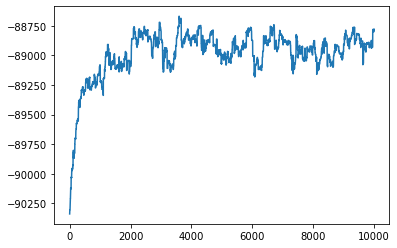

In [130]:
plt.plot(range(len(nb_mcmc.ll_iter)), nb_mcmc.ll_iter) 

In [20]:
residuals = []
for clust in nb_mcmc.clusters:
    residuals.append(np.exp(np.log(clust.r.flatten()) - (clust.mu.flatten()) - (clust.C@clust.beta).flatten()))

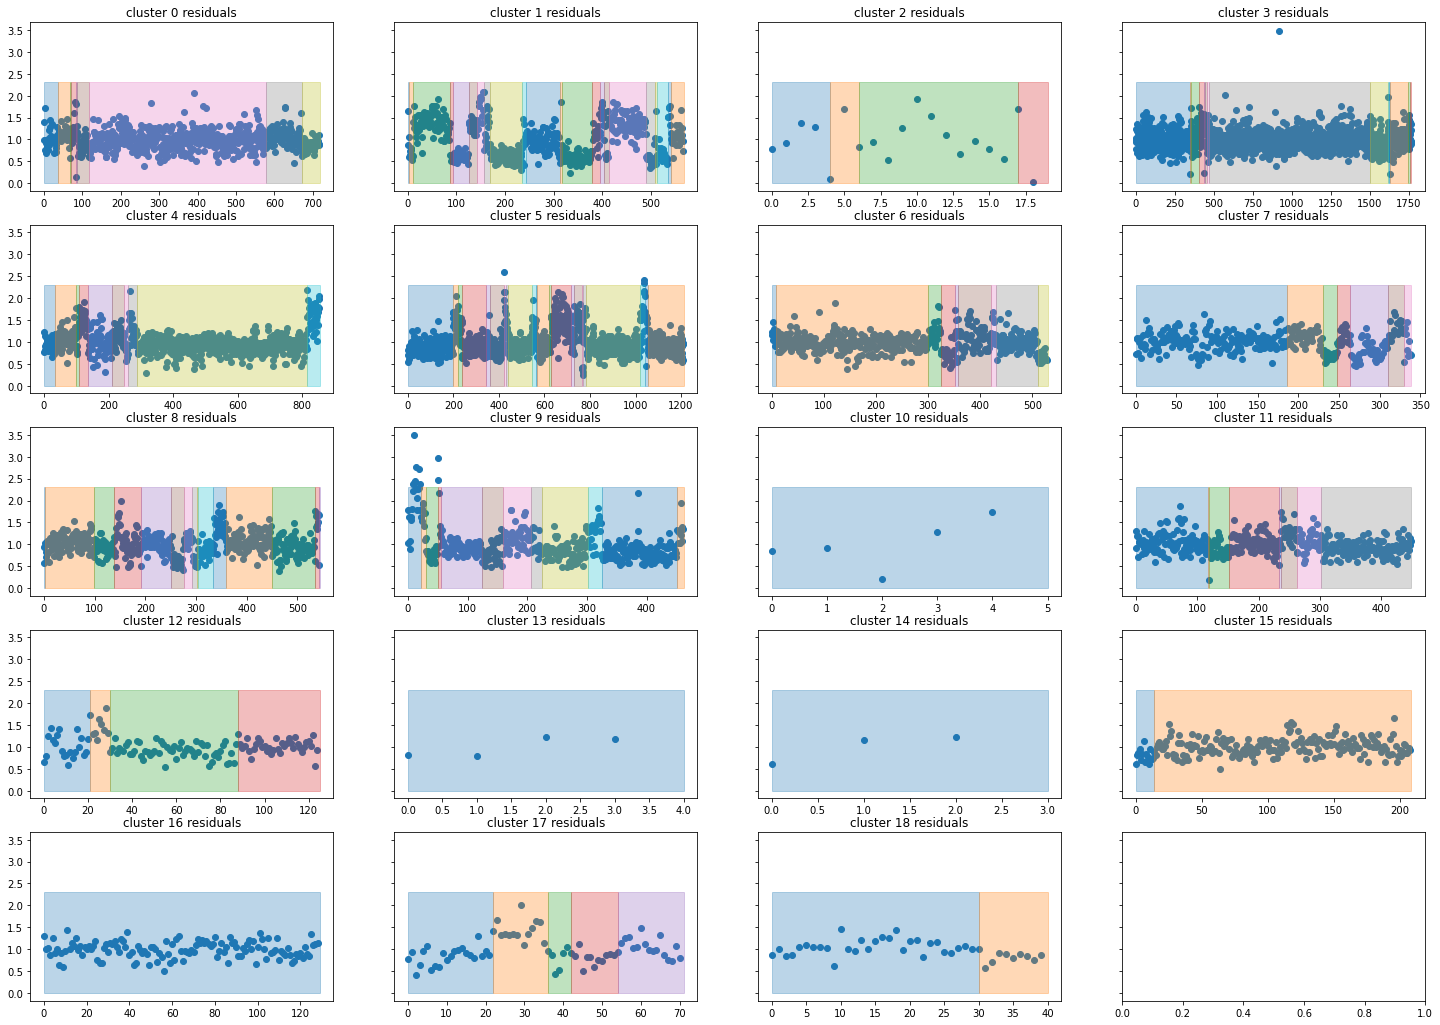

In [21]:
fig , axs = plt.subplots(5,4, figsize = (25,18), sharey=True)
ax_lst = axs.flatten()
for targ, cov_idx in Cov_overlap.groupby("cluster_assgn").indices.items():
    ax_lst[targ].scatter(np.r_[:len(residuals[targ])], residuals[targ])
    ax_lst[targ].set_title('cluster {} residuals'.format(targ))
    if len(nb_mcmc.F_samples[0][targ]) > 0:
        hist = np.array(nb_mcmc.F_samples[0][targ]).reshape(-1,2)
        for j, r in enumerate(hist):
            ax_lst[targ].add_patch(matplotlib.patches.Rectangle((r[0],0), r[1]-r[0], 2.3, fill=True, alpha=0.3, color = colors[j % 10]))

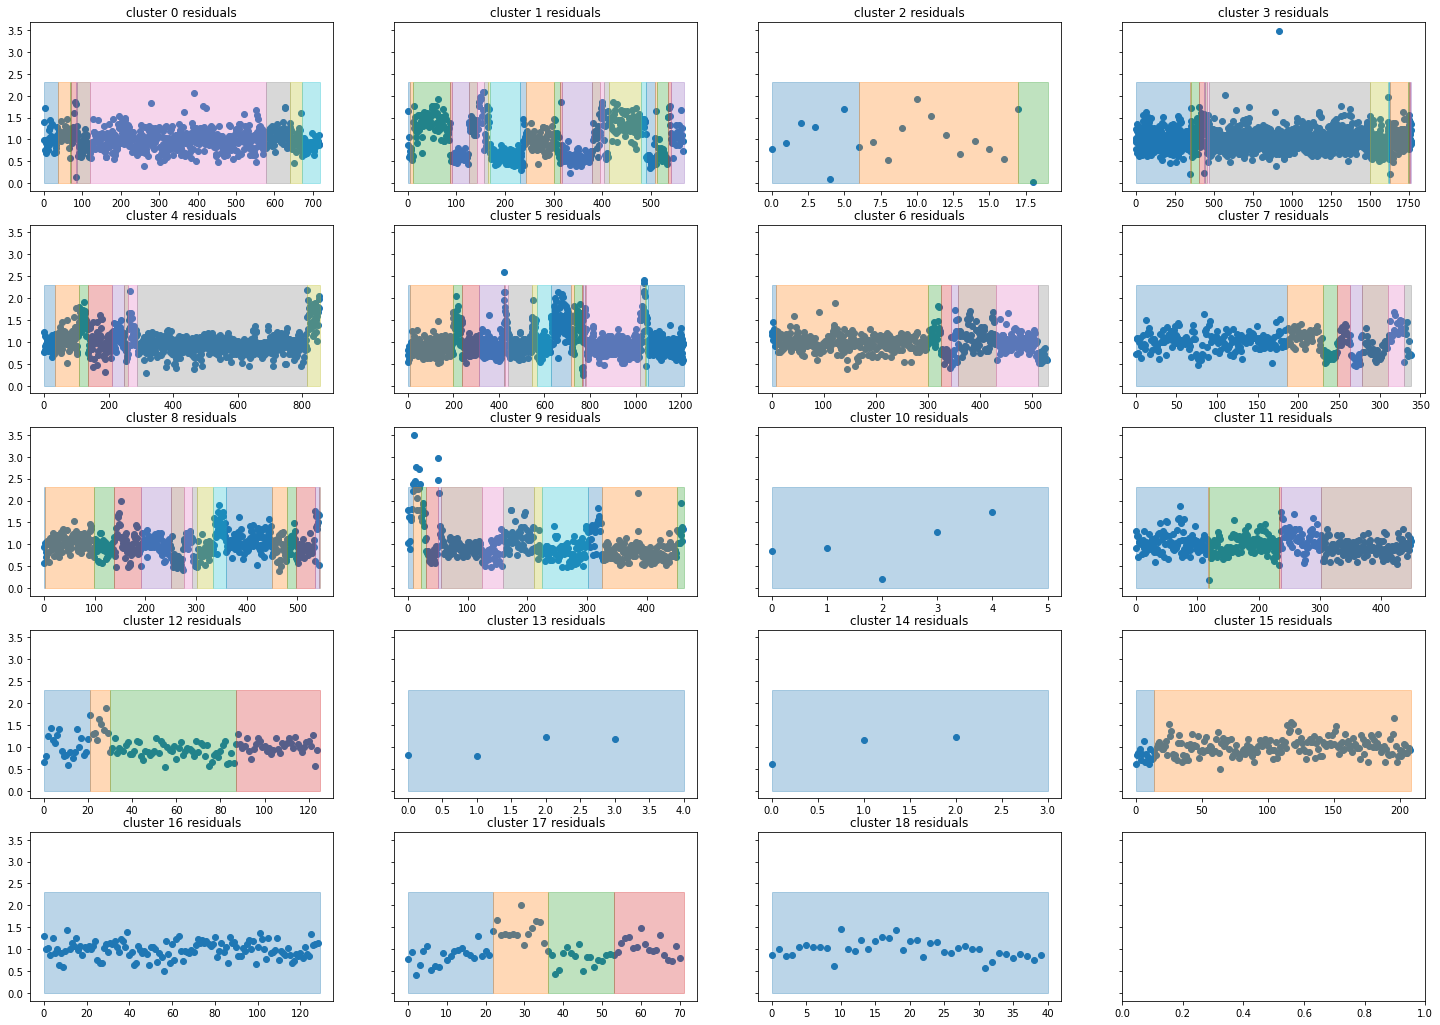

In [79]:
fig , axs = plt.subplots(5,4, figsize = (25,18), sharey=True)
ax_lst = axs.flatten()
samp = 3
for targ, cov_idx in Cov_overlap.groupby("cluster_assgn").indices.items():
    ax_lst[targ].scatter(np.r_[:len(residuals[targ])], residuals[targ])
    ax_lst[targ].set_title('cluster {} residuals'.format(targ))
    if len(nb_mcmc.F_samples[samp][targ]) > 0:
        hist = np.array(nb_mcmc.F_samples[samp][targ]).reshape(-1,2)
        for j, r in enumerate(hist):
            ax_lst[targ].add_patch(matplotlib.patches.Rectangle((r[0],0), r[1]-r[0], 2.3, fill=True, alpha=0.3, color = colors[j % 10]))

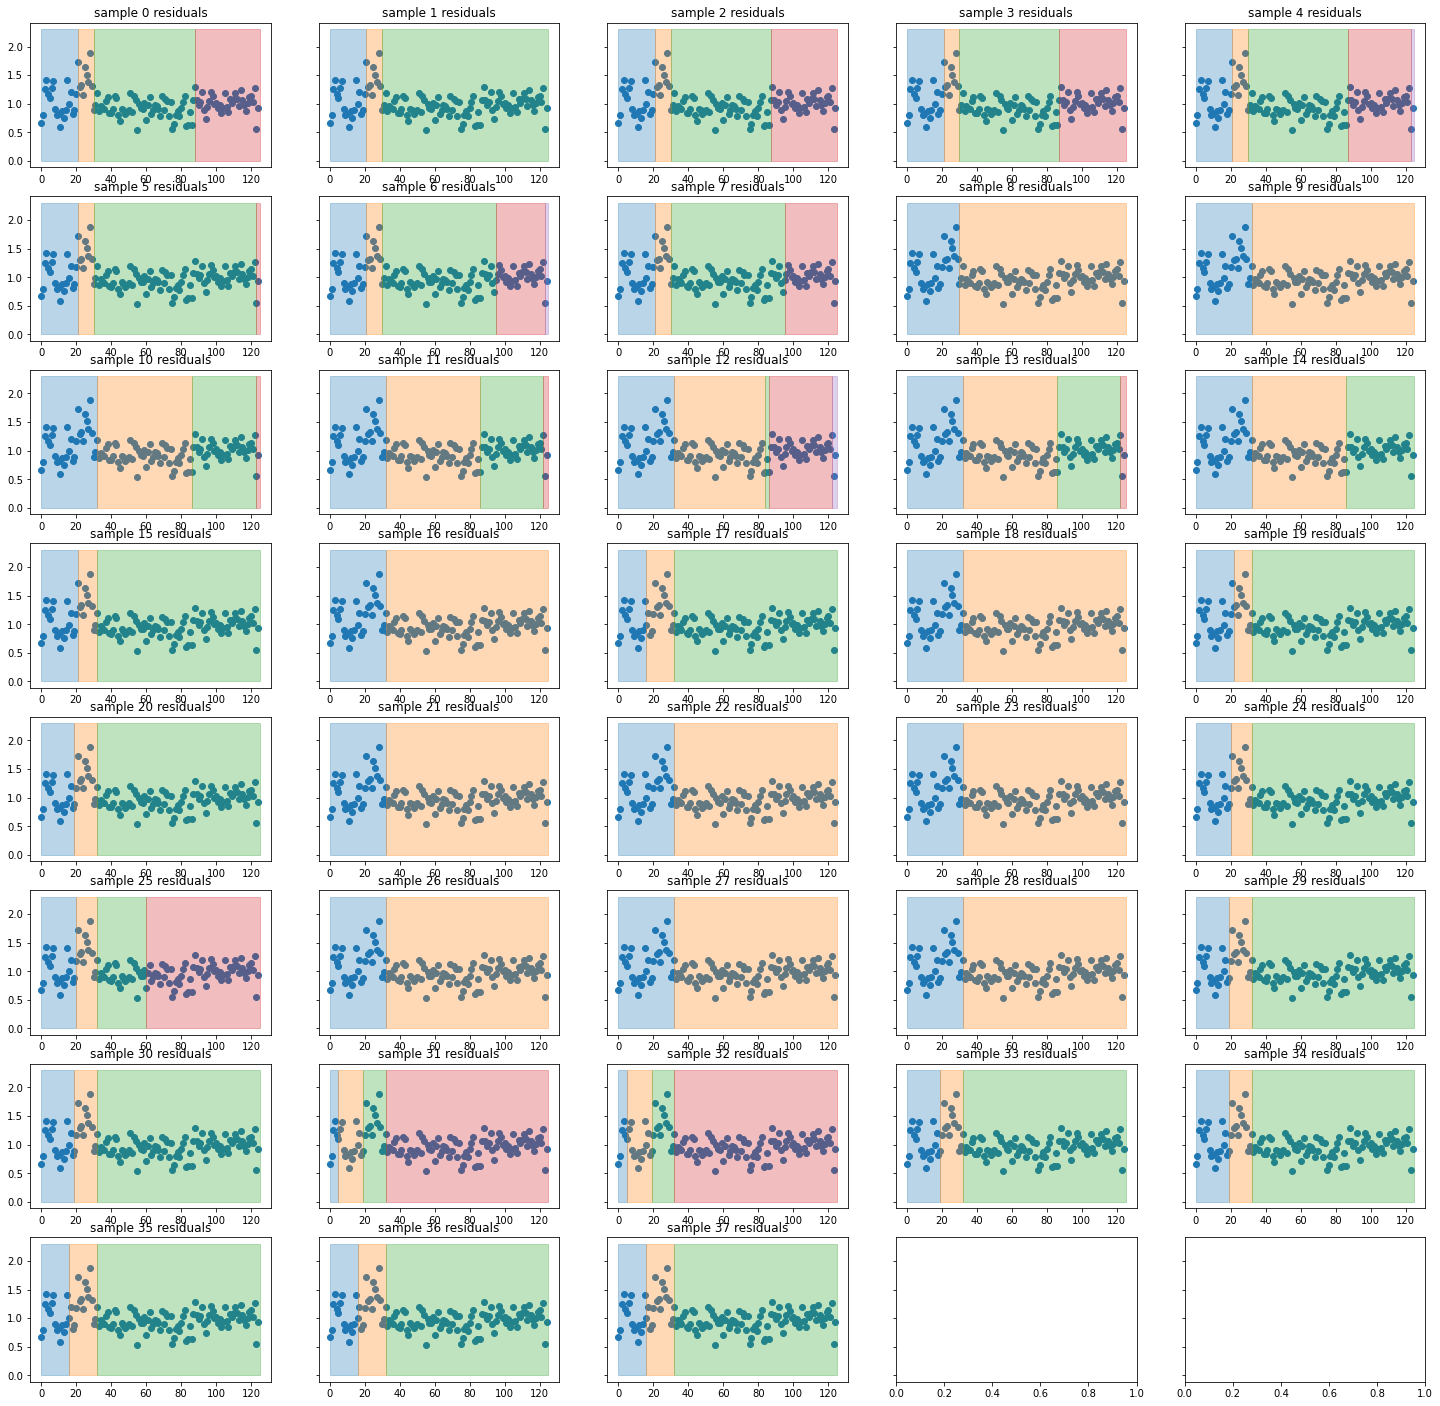

In [91]:
fig , axs = plt.subplots(8,5, figsize = (25,25), sharey=True)
ax_lst = axs.flatten()
clust = 12
for samp in range(len(nb_mcmc.F_samples)):
    ax_lst[samp].scatter(np.r_[:len(residuals[clust])], residuals[clust])
    ax_lst[samp].set_title('sample {} residuals'.format(samp))
    if len(nb_mcmc.F_samples[samp][clust]) > 0:
        hist = np.array(nb_mcmc.F_samples[samp][clust]).reshape(-1,2)
        for j, r in enumerate(hist):
            ax_lst[samp].add_patch(matplotlib.patches.Rectangle((r[0],0), r[1]-r[0], 2.3, fill=True, alpha=0.3, color = colors[j % 10]))

In [101]:
tst = [nb_mcmc.clusters[0].r, nb_mcmc.clusters[1].r, nb_mcmc.clusters[2].r]

In [124]:
values = map(lambda k, v: if k != 1: v, d.keys())

SyntaxError: invalid syntax (<ipython-input-124-f10d044c6147>, line 1)

In [126]:
tst_dict = sc.SortedDict({0:1, 1:2})

In [129]:
[value for (key,value) in tst_dict.items() if key != 0]

[2]

In [110]:
np.concatenate([nb_mcmc.clusters[0].C, nb_mcmc.clusters[1].C]).shape

(1286, 3)

In [37]:
residuals[12][:20]

array([0.66272526, 0.79464723, 1.24792166, 1.42017148, 1.16587883,
       1.09174663, 1.2718178 , 1.39691487, 0.90258578, 0.79578544,
       0.82468784, 0.58520123, 0.87400298, 0.75578799, 0.89112182,
       1.41090583, 0.99345844, 1.1960743 , 0.81727044, 0.88691078])

In [38]:
residuals[12][12:20]

array([0.87400298, 0.75578799, 0.89112182, 1.41090583, 0.99345844,
       1.1960743 , 0.81727044, 0.88691078])

In [42]:
nb_mcmc.clusters[12].stats_optimizer((0,2))

(-0.3165120303452187, 8.189200911456094)

In [32]:
nb_mcmc.clusters[12].stats_optimizer((2,25))

(0.09177083608106092, 2.8746992242519487)

In [41]:
nb_mcmc.clusters[12].calc_pk((0,16), debug=True)

(array([-1459.54498228, -1439.18558751, -1439.34121851, -1439.32619245,
        -1439.2444053 , -1438.77856908, -1437.54701365, -1437.89883224,
        -1438.5058212 , -1438.82611799, -1439.39463466, -1439.47074767,
        -1439.12275672]),
 3,
 -1439.185587511988,
 0.05006798725737678,
 (-0.10340163759204331, 0.029305485518938964),
 (2.7137773306054647, 2.747470973023267),
 (array([[-4.12745226e+01, -5.47466072e-09],
         [-5.47466072e-09, -2.91073701e+02]]),
  array([[-1.86533148e+02, -2.88751778e-08],
         [-2.88751778e-08, -1.35856081e+03]])))

In [98]:
nb_mcmc.clusters[12].ll_nbinom(nb_mcmc.clusters[12].r[:2], nb_mcmc.clusters[12].mu, nb_mcmc.clusters[12].C[:2], nb_mcmc.clusters[12].beta, -0.31, 3.5)

-19.806546469271694

In [94]:
nb_mcmc.clusters[12].ll_nbinom(nb_mcmc.clusters[12].r[:2], nb_mcmc.clusters[12].mu, nb_mcmc.clusters[12].C[:2], nb_mcmc.clusters[12].beta, -0.31, 8.1)

-40.081240409516795

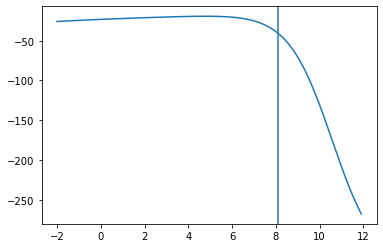

In [86]:
eps = np.r_[-2:12:0.1]
res = []
for ep in eps:
    res.append(nb_mcmc.clusters[12].ll_nbinom(nb_mcmc.clusters[12].r[:2], nb_mcmc.clusters[12].mu, nb_mcmc.clusters[12].C[:2], nb_mcmc.clusters[12].beta, -0.3, ep))
plt.plot(eps, res)
plt.axvline(8.1)

In [61]:
from statsmodels.discrete.discrete_model import NegativeBinomial as statsNB

In [89]:
def stats_optimizer(self, ind, ret_hess=False):
    endog = np.exp(np.log(self.r[ind[0]:ind[1]].flatten()) - (self.C[ind[0]:ind[1]] @ self.beta).flatten())
    exog = np.ones(self.r[ind[0]:ind[1]].shape[0])
    exposure = np.ones(self.r[ind[0]:ind[1]].shape[0]) * np.exp(self.mu)
    sNB = statsNB(endog, exog, exposure=exposure)
    res = sNB.fit(method='bfgs',disp=0)

    if ret_hess:
        return res.params[0], -np.log(res.params[1]), sNB.hessian(res.params)
    else:
        return res.params[0], -np.log(res.params[1])

In [90]:
stats_optimizer(nb_mcmc.clusters[12],(0,2))

(-0.3165120303452187, 8.189200911456094)

In [131]:
overlap_tst = Cov_overlap.copy()

In [132]:
overlap_tst['segment_ID'] = 0

In [133]:
seg_id_col = overlap_tst.columns.get_loc('segment_ID')

In [134]:
#convert Cov_MCMC object into segment objects to be used by cov_DP

global_seg_counter = 0
for i, clust in enumerate(nb_mcmc.clusters):
    pi_argmax = Pi.argmax(1)
    og_positions = np.where(pi_argmax == i)[0]
    seg_intervals = np.array(clust.F).reshape(-1,2)
    for st, en in seg_intervals:
        seg_ind = og_positions[st:en]
        overlap_tst.iloc[seg_ind, seg_id_col] = global_seg_counter
        global_seg_counter += 1

In [136]:
overlap_tst.to_pickle('./cov_MCMC_df')

In [138]:
np.save('./beta_save', nb_mcmc.beta)